In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
coin_ids = {
    'Bitcoin': 1442,
    'Bitcoin Cash': 1445,
    'Bitcoin Gold': 1456,
    'Cardano': 1446,
    'Dash': 1453,
    'Dogecoin': 1477,
    'Eos': 1452,
    'Ethereum': 1443,
    'Ethereum Classic': 1457,
    'Iota': 1451,
    'Lisk': 1460,
    'Litecoin': 1448,
    'Monero': 1454,
    'NEMcoin': 1447,
    'Neo': 1449,
    'Ripple': 1444,
    'Stellar': 1450,
    'Tether': 1474,
    'Tron': 1455,
    'Zcash': 1465,
}

id_coins = {v: k for k, v in coin_ids.items()}



In [41]:
### load data:

iterator_full_data = pd.read_csv('data/datathon.csv', iterator=True, chunksize=100000, parse_dates=['time'])
subset_full_data = pd.concat([chunk[chunk.refID_coin.isin(coin_ids.values())] for chunk in iterator_full_data])
subset_full_data = subset_full_data.replace({'refID_coin': id_coins})

### There are some duplicate rows, as well as some rows that should exist, but don't:

subset_full_data[subset_full_data[['time', 'refID_coin']].duplicated()].shape

first_period = subset_full_data.time.min()
last_period = subset_full_data.time.max()
all_periods = pd.date_range(start=first_period, end=last_period, freq='5min')
all_currencies = subset_full_data.refID_coin.unique()
full_index = pd.MultiIndex.from_product([all_periods, all_currencies])
subset_full_data = (subset_full_data
                    .drop_duplicates(subset=['time', 'refID_coin'])
                    .set_index(['time', 'refID_coin'])
                    .reindex(full_index, fill_value = np.nan)
                    .reset_index()
                    .rename({'level_0': 'time', 'level_1': 'refID_coin'}, axis=1))

### fill missing values:

numeric_cols = ['price', 'marketCap', 'CirculatingSupply', 'Volume24h', 'Movement1h', 'Movement24h']

subset_full_data[numeric_cols] = subset_full_data.groupby('refID_coin')[numeric_cols].transform(lambda x: x.fillna(method='ffill'))

In [42]:
print(len(all_currencies))
print(len(all_periods))

20
18752


## Calculate marketCap % for each currency by period

In [43]:
market_caps = subset_full_data[['time', 'refID_coin', 'marketCap']]
market_caps = market_caps.pivot(index='time', columns='refID_coin', values='marketCap')
market_caps['total_market_cap'] = market_caps.sum(axis=1)

for currency in coin_ids.keys():
    market_caps[currency] = market_caps[currency] / market_caps['total_market_cap']

# market_caps.drop('total_market_cap', axis=1, inplace=True) 
market_caps.head()

refID_coin,Bitcoin,Bitcoin Cash,Bitcoin Gold,Cardano,Dash,Dogecoin,Eos,Ethereum,Ethereum Classic,Iota,...,Litecoin,Monero,NEMcoin,Neo,Ripple,Stellar,Tether,Tron,Zcash,total_market_cap
time,,,,,,,,,,,,,,,,,,,,,
2018-01-17 11:25:00,0.417511,0.068137,0.007041,0.032588,0.013760,0.001783,0.013430,0.215335,0.006446,0.015947,...,0.022289,0.011281,0.018439,0.017993,0.100762,0.016991,0.003859,0.007959,0.003326,4.330098e+11
2018-01-17 11:30:00,0.417944,0.067944,0.007038,0.032608,0.013672,0.001783,0.013414,0.214956,0.006423,0.016005,...,0.022250,0.011292,0.018517,0.017931,0.101045,0.017000,0.003843,0.007919,0.003316,4.338520e+11
2018-01-17 11:35:00,0.417660,0.068123,0.007029,0.032462,0.013670,0.001788,0.013464,0.214553,0.006418,0.016131,...,0.022219,0.011309,0.018693,0.017961,0.101278,0.016983,0.003832,0.007974,0.003316,4.349272e+11
2018-01-17 11:40:00,0.417660,0.068123,0.007029,0.032462,0.013670,0.001788,0.013464,0.214553,0.006418,0.016131,...,0.022219,0.011309,0.018693,0.017961,0.101278,0.016983,0.003832,0.007974,0.003316,4.349272e+11
2018-01-17 11:45:00,0.418812,0.068159,0.007042,0.032333,0.013661,0.001791,0.013402,0.214265,0.006384,0.016138,...,0.022220,0.011267,0.018605,0.018020,0.100740,0.016920,0.003840,0.007938,0.003304,4.324727e+11


In [2]:
import pandas as pd
import numpy as np

## Calculate market entropy for each period

In [44]:
def calculate_entropy(values):
    return - sum(values * np.log2(values.astype('float64')))

In [45]:
market_caps['market_entropy'] = market_caps.apply(lambda x: calculate_entropy(x[coin_ids.keys()]), axis=1)

In [46]:
market_caps.head()

refID_coin,Bitcoin,Bitcoin Cash,Bitcoin Gold,Cardano,Dash,Dogecoin,Eos,Ethereum,Ethereum Classic,Iota,...,Monero,NEMcoin,Neo,Ripple,Stellar,Tether,Tron,Zcash,total_market_cap,market_entropy
time,,,,,,,,,,,,,,,,,,,,,
2018-01-17 11:25:00,0.417511,0.068137,0.007041,0.032588,0.013760,0.001783,0.013430,0.215335,0.006446,0.015947,...,0.011281,0.018439,0.017993,0.100762,0.016991,0.003859,0.007959,0.003326,4.330098e+11,2.797659
2018-01-17 11:30:00,0.417944,0.067944,0.007038,0.032608,0.013672,0.001783,0.013414,0.214956,0.006423,0.016005,...,0.011292,0.018517,0.017931,0.101045,0.017000,0.003843,0.007919,0.003316,4.338520e+11,2.796498
2018-01-17 11:35:00,0.417660,0.068123,0.007029,0.032462,0.013670,0.001788,0.013464,0.214553,0.006418,0.016131,...,0.011309,0.018693,0.017961,0.101278,0.016983,0.003832,0.007974,0.003316,4.349272e+11,2.798585
2018-01-17 11:40:00,0.417660,0.068123,0.007029,0.032462,0.013670,0.001788,0.013464,0.214553,0.006418,0.016131,...,0.011309,0.018693,0.017961,0.101278,0.016983,0.003832,0.007974,0.003316,4.349272e+11,2.798585
2018-01-17 11:45:00,0.418812,0.068159,0.007042,0.032333,0.013661,0.001791,0.013402,0.214265,0.006384,0.016138,...,0.011267,0.018605,0.018020,0.100740,0.016920,0.003840,0.007938,0.003304,4.324727e+11,2.795677


In [67]:
market_caps.to_csv('data/market_caps_by_period.csv')

In [3]:
market_caps = pd.read_csv('data/market_caps_by_period.csv')

In [4]:
market_caps.head()

,time,Bitcoin,Bitcoin Cash,Bitcoin Gold,Cardano,Dash,Dogecoin,Eos,Ethereum,Ethereum Classic,...,Monero,NEMcoin,Neo,Ripple,Stellar,Tether,Tron,Zcash,total_market_cap,market_entropy
0,2018-01-17 11:25:00,0.417511,0.068137,0.007041,0.032588,0.013760,0.001783,0.013430,0.215335,0.006446,...,0.011281,0.018439,0.017993,0.100762,0.016991,0.003859,0.007959,0.003326,4.330098e+11,2.797659
1,2018-01-17 11:30:00,0.417944,0.067944,0.007038,0.032608,0.013672,0.001783,0.013414,0.214956,0.006423,...,0.011292,0.018517,0.017931,0.101045,0.017000,0.003843,0.007919,0.003316,4.338520e+11,2.796498
2,2018-01-17 11:35:00,0.417660,0.068123,0.007029,0.032462,0.013670,0.001788,0.013464,0.214553,0.006418,...,0.011309,0.018693,0.017961,0.101278,0.016983,0.003832,0.007974,0.003316,4.349272e+11,2.798585
3,2018-01-17 11:40:00,0.417660,0.068123,0.007029,0.032462,0.013670,0.001788,0.013464,0.214553,0.006418,...,0.011309,0.018693,0.017961,0.101278,0.016983,0.003832,0.007974,0.003316,4.349272e+11,2.798585
4,2018-01-17 11:45:00,0.418812,0.068159,0.007042,0.032333,0.013661,0.001791,0.013402,0.214265,0.006384,...,0.011267,0.018605,0.018020,0.100740,0.016920,0.003840,0.007938,0.003304,4.324727e+11,2.795677


Correlation between total market cap and market entropy:

In [5]:
market_caps.market_entropy.corr(market_caps.total_market_cap)

0.68022486615660249

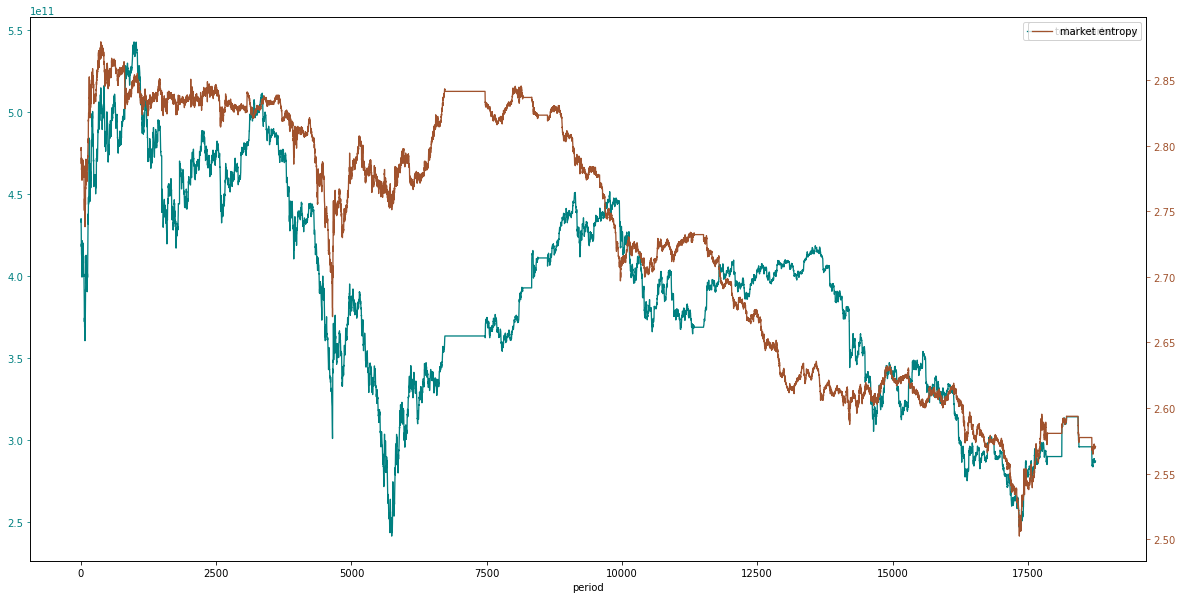

In [36]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20, 10)

fig, ax1 = plt.subplots()

ax1.plot(market_caps.index, market_caps.total_market_cap, '-', color='teal', linewidth=1.3, label='total market cap')
ax1.set_xlabel('period')
ax1.tick_params('y', colors='teal')
ax1.legend(loc=0)

ax2 = ax1.twinx()
ax2.plot(market_caps.index, market_caps.market_entropy, '-', color='sienna', linewidth=1.3, label='market entropy')
ax2.set_xlabel('period')
ax2.tick_params('y', colors='sienna')
ax2.legend(loc=0)